PCA-SIFT with undersampling (on person class for COCO dataset) and optional oversampling

In [1]:
from pycocotools.coco import COCO
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
data_type = 'val2017'
ann_file = 'dataset/coco/annotations/instances_{}.json'.format(data_type)

coco = COCO(ann_file)

loading annotations into memory...
Done (t=0.28s)
creating index...
index created!


In [3]:
# all categories (with ids)
cats = coco.loadCats(coco.getCatIds())

# load data
img_ids = [coco.dataset['images'][i]['id'] for i in range(len(coco.dataset['images']))]
img_ids_w_filename = {coco.dataset['images'][i]['id']: coco.dataset['images'][i]['file_name'] for i in range(len(coco.dataset['images']))}      # use dictionary for faster query
annotations = coco.loadAnns(coco.getAnnIds(imgIds=img_ids))

In [4]:
# load labels for each imgs (as one img may have multiple labels)
labels_per_imgs = []
for i in range(len(img_ids)):
    labels_per_imgs.append(coco.loadAnns(coco.getAnnIds(imgIds=img_ids[i])))

In [5]:
# now we create the real list of datasets

img_id_w_bb = []
label_per_obj = []

for labels in labels_per_imgs:
    for l in labels:
        img_id_w_bb.append((l['id'], l['image_id'], l['bbox']))
        label_per_obj.append(l['category_id'])

Create train-test split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(img_id_w_bb, label_per_obj, test_size=0.2, random_state=42)

In [7]:
X_train

[(2200577, 561958, [203.21, 206.04, 24.1, 83.3]),
 (1234599, 208363, [528.43, 110.91, 87.51, 109.27]),
 (454570, 256775, [380.57, 313.77, 34.23, 98.68]),
 (1181286, 191845, [10.03, 158.27, 17.89, 32.9]),
 (1803061, 172935, [124.93, 262.44, 132.12, 26.06]),
 (100906, 186980, [45.42, 287.66, 196.82, 344.08]),
 (1317738, 210394, [454.7, 229.43, 9.17, 18.84]),
 (25758, 31735, [544.72, 188.61, 56.61, 75.76]),
 (1507874, 492878, [188.53, 244.23, 95.68, 153.09]),
 (1435276, 38048, [276.35, 207.36, 8.63, 18.25]),
 (1798643, 293324, [301.7, 305.91, 14.81, 21.09]),
 (1464177, 450439, [18.17, 155.82, 137.1, 60.01]),
 (1660393, 31248, [81.99, 161.88, 5.91, 26.66]),
 (560922, 247917, [307.79, 199.92, 51.78, 112.93]),
 (1898153, 91654, [34.73, 0.0, 602.79, 460.27]),
 (1584166, 422836, [154.67, 163.5, 8.2, 21.39]),
 (357416, 376284, [209.88, 28.09, 61.94, 31.86]),
 (1414647, 311295, [245.11, 179.76, 46.51, 59.62]),
 (1655724, 421923, [185.34, 207.15, 115.07, 14.91]),
 (528558, 274708, [338.04, 199.23

In [8]:
# using HuggingFace datasets to optimize memory usage

from pathlib import Path
from datasets import Dataset

# 1. First, prepare your data for the datasets library
def prepare_dataset_dict(X, img_ids_w_filename):
    # Create a lightweight dictionary containing only metadata (not images)
    dataset_dict = {
        "image_id": [],
        "bbox": [],
        "file_name": []
    }
    
    for sample in X:
        dataset_dict["image_id"].append(sample[1])
        dataset_dict["bbox"].append(sample[2])
        dataset_dict["file_name"].append(img_ids_w_filename[sample[1]])
        
    return dataset_dict

# 2. Define the SIFT processing function

def process_image_with_sift(example):
    """Process a single image, extracting SIFT features"""
    # Load image only when needed
    img_path = Path(f"dataset/coco/val2017/{example['file_name']}")
    img = cv2.imread(str(img_path))
    
    # Apply bounding box
    x, y, w, h = example['bbox']
    img_cropped = img[int(y): int(y + h) + 1, int(x):int(x + w) + 1]
    
    # Convert to grayscale
    img_gray = cv2.cvtColor(img_cropped, cv2.COLOR_BGR2GRAY)
    
    # Apply SIFT
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img_gray, None)
    
    # Convert keypoints to serializable format
    serialized_keypoints = []
    for kp in keypoints:
        serialized_keypoints.append({
            'x': float(kp.pt[0]),
            'y': float(kp.pt[1]), 
            'size': float(kp.size),
            'angle': float(kp.angle),
            'response': float(kp.response),
            'octave': int(kp.octave)
        })
    
    # Return only the features, together with the image_id, bbox, and filename
    # but not the image (pixel) itself
    return {
        'image_id': example['image_id'],
        'bbox': example['bbox'],
        'file_name': example['file_name'],
        'keypoints': serialized_keypoints,
        'descriptors': descriptors.tolist() if descriptors is not None else []
    }

# 3. Main pipeline
def create_sift_dataset(X_train, img_ids_w_filename):
    # Create the dataset dictionary
    dataset_dict = prepare_dataset_dict(X_train, img_ids_w_filename)
    
    # Create HF dataset
    raw_dataset = Dataset.from_dict(dataset_dict)
    
    # Process using (optional) multi-processing
    processed_dataset = raw_dataset.map(
        process_image_with_sift,
        num_proc=2,
        batched=False,
        desc="Extracting SIFT features"
    )
    
    return processed_dataset


/root/miniforge3/envs/comp61342_asm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
sift_dataset_training = create_sift_dataset(X_train, img_ids_w_filename)

Extracting SIFT features (num_proc=2): 100%|██████████| 29424/29424 [01:23<00:00, 353.25 examples/s]


In [10]:
len(sift_dataset_training)

29424

In [11]:
sift_dataset_training[0]

{'image_id': 561958,
 'bbox': [203.21, 206.04, 24.1, 83.3],
 'file_name': '000000561958.jpg',
 'keypoints': [{'angle': 45.48919677734375,
   'octave': 6882303,
   'response': 0.020551029592752457,
   'size': 3.134206771850586,
   'x': 3.9260289669036865,
   'y': 23.838598251342773},
  {'angle': 103.79199981689453,
   'octave': 12845567,
   'response': 0.04137100651860237,
   'size': 2.1448497772216797,
   'x': 5.66931676864624,
   'y': 78.18323516845703},
  {'angle': 257.2601013183594,
   'octave': 12845567,
   'response': 0.04137100651860237,
   'size': 2.1448497772216797,
   'x': 5.66931676864624,
   'y': 78.18323516845703},
  {'angle': 29.124374389648438,
   'octave': 6423296,
   'response': 0.01408716756850481,
   'size': 6.229495525360107,
   'x': 6.97819709777832,
   'y': 47.19277572631836},
  {'angle': 321.76837158203125,
   'octave': 6423296,
   'response': 0.01408716756850481,
   'size': 6.229495525360107,
   'x': 6.97819709777832,
   'y': 47.19277572631836},
  {'angle': 163.7

Do some EDA to view class balance

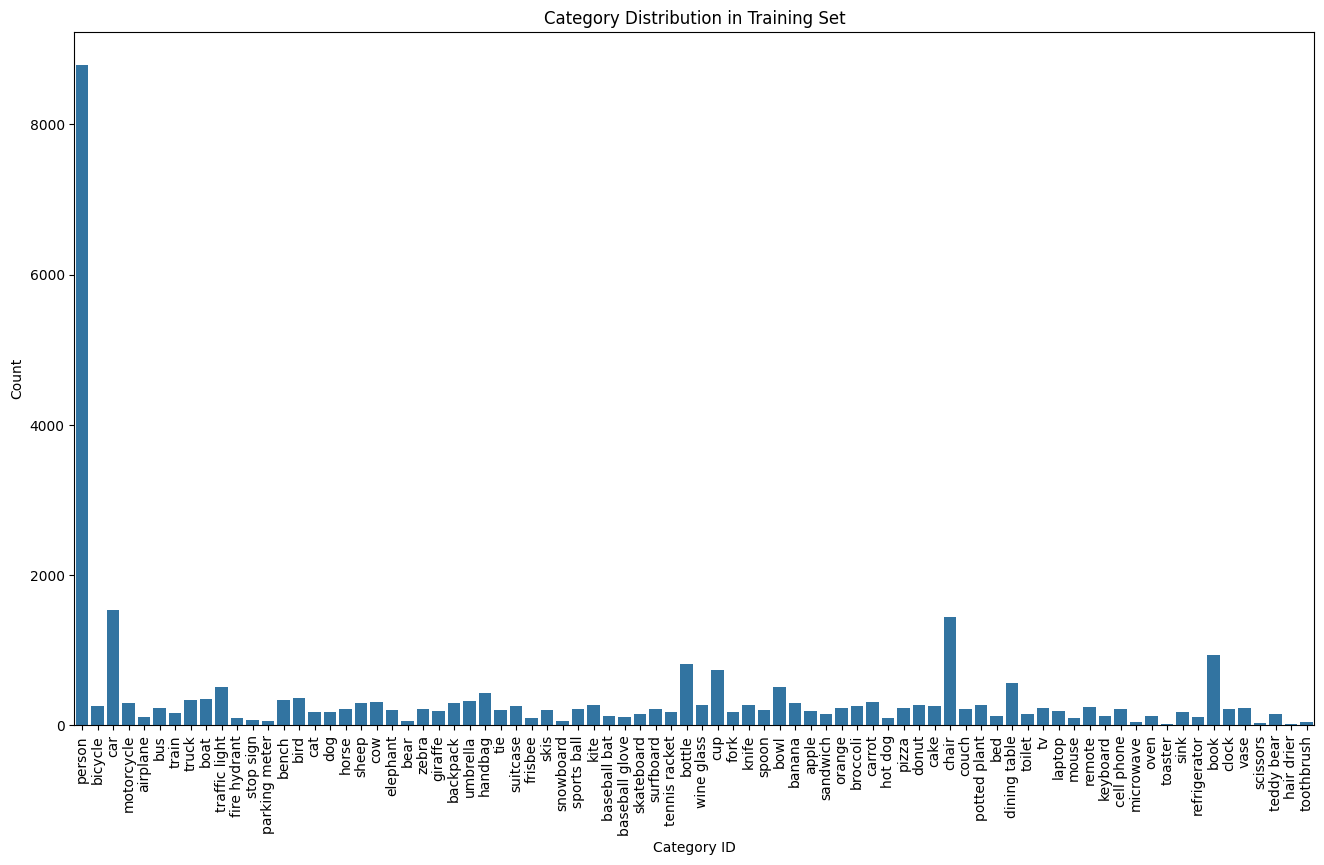

In [12]:
# view y_train categories and counts
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Convert to DataFrame for easier plotting
df = pd.DataFrame({'category_id': y_train})
# Count occurrences of each category
category_counts = df['category_id'].value_counts().reset_index()
category_counts.columns = ['category_id', 'count']
# Plot
plt.figure(figsize=(16,9))
sns.barplot(x='category_id', y='count', data=category_counts)
plt.title('Category Distribution in Training Set')
plt.xlabel('Category ID')
plt.ylabel('Count')
# set x-ticks to be the category names
category_names = [d['name'] for d in cats]
plt.xticks(range(len(category_names)), category_names)
plt.xticks(rotation=90)
plt.show()

Notice that the whole dataset is very skewwed toward "person" category

We need to tackle the data imbalance

In [13]:
# get all keypoints and descriptors
all_keypoints = []
all_descriptors = []

descriptors_to_idx = {}
_count = 0

for example in sift_dataset_training:
    all_keypoints.extend(example['keypoints'])
    all_descriptors.extend(example['descriptors'])

    # add to descriptors_to_idx
    descriptors_to_idx[example['image_id']] = (_count, _count + len(example['descriptors']))
    _count += len(example['descriptors'])

len(all_keypoints), len(all_descriptors)
# convert to numpy array
all_keypoints_np = np.array(all_keypoints)
all_descriptors_np = np.array(all_descriptors)

In [14]:
# check if there are any tuple which differrence = 1 in the descriptors_to_idx
i = 0
for k, v in descriptors_to_idx.items():
    if v[1] - v[0] == 1:
        print(k, v)
        i += 1

print(i)

344888 (3337956, 3337957)
36936 (3085936, 3085937)
210273 (3290757, 3290758)
350023 (3271480, 3271481)
529568 (3350410, 3350411)
292446 (2814410, 2814411)
474021 (2585801, 2585802)
377946 (2851687, 2851688)
447342 (3138586, 3138587)
308587 (2858490, 2858491)
432898 (3289952, 3289953)
125778 (3017859, 3017860)
554291 (3146151, 3146152)
154358 (3261862, 3261863)
106389 (3109723, 3109724)
470924 (3306579, 3306580)
378873 (3347727, 3347728)
174482 (3246436, 3246437)
13348 (3136410, 3136411)
115946 (2924462, 2924463)
144706 (3310444, 3310445)
43314 (3130913, 3130914)
212573 (3265592, 3265593)
467176 (3351808, 3351809)
484351 (3270035, 3270036)
423229 (2885208, 2885209)
69356 (3351161, 3351162)
184611 (3341213, 3341214)
252559 (2739454, 2739455)
99039 (3214536, 3214537)
458663 (3188210, 3188211)
129416 (2355258, 2355259)
169996 (3307354, 3307355)
304812 (1479355, 1479356)
250282 (3126427, 3126428)
483667 (1693131, 1693132)
60823 (3233993, 3233994)
530836 (2607398, 2607399)
215259 (3164367, 3

Model

Then PCA -> (oversampling?) -> K-Mean -> (oversampling/undersampling) -> SVM

In [15]:
# First apply PCA to all descriptors
from sklearn.decomposition import PCA

PCA_N_COMPONENTS = 20

pca = PCA(n_components=PCA_N_COMPONENTS)
pca.fit(all_descriptors_np)
# Transform the descriptors
descriptors_pca = pca.transform(all_descriptors_np)

Perform KMeans to build visual words and vector quantization

Refer to this article for implementation (but use scikit-learn instead of scipy for faster performance)

https://www.pinecone.io/learn/series/image-search/bag-of-visual-words/

In [16]:
from sklearn.cluster import KMeans

K = 200     # number of clusters = number of visual words
kmeans = KMeans(n_clusters=K, random_state=42)
kmeans.fit(descriptors_pca)

kmean_cluster_centers = kmeans.cluster_centers_

In [17]:
# extend the dataset with the cluster id (equivalent to vector quantization)
def assign_cluster_id(example, kmeans):
    """Assign cluster id to each keypoint based on the closest cluster center"""
    # Update the example with the cluster ids

    # des = np.array(example['descriptors'])

    # Apply PCA to the original descriptors
    red_des = descriptors_pca[descriptors_to_idx[example['image_id']][0]: descriptors_to_idx[example['image_id']][1]]

    # early return if no descriptors
    if red_des.size == 0:
        example['cluster_ids'] = np.array([], dtype=np.int32)
        return example

    if red_des.ndim == 1:
        example['cluster_ids'] = kmeans.predict(red_des.reshape(1, -1))
    else:
        example['cluster_ids'] = kmeans.predict(red_des)
    
    return example

# Apply the filter to the dataset
sift_dataset_training = sift_dataset_training.map(
    assign_cluster_id,
    fn_kwargs={'kmeans': kmeans},
    num_proc=1,
    desc="Assigning cluster ids to keypoints"
)

Assigning cluster ids to keypoints: 100%|██████████| 29424/29424 [00:10<00:00, 2838.36 examples/s]


In [18]:
# create a histogram of the cluster ids
# that will be used to compute TF-IDF

def create_histogram(example):
    """Create a histogram of cluster ids"""

    # early exit if descriptors are empty -> cluster_ids will be empty too
    if len(example['descriptors']) == 0:
        example['histogram'] = np.array([[]], dtype=np.int64)
        return example
    

    hist, _ = np.histogram(example['cluster_ids'], bins=np.arange(K + 1))
    
    example['histogram'] = hist.reshape(-1, K)

    return example

# Apply the histogram function to the dataset
sift_dataset_training = sift_dataset_training.map(
    create_histogram,
    num_proc=1,
    desc="Creating histogram of cluster ids"
)

Creating histogram of cluster ids: 100%|██████████| 29424/29424 [01:45<00:00, 278.10 examples/s]


Then use TF-IDF to create histogram for every image

In [19]:
# create histogram using TF-IDF
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

# grab all non-empty histograms and concat them to a very large 2D array
des_histo = np.concatenate(
    [example['histogram'] for example in sift_dataset_training if len(example['histogram'][0]) > 0],
    axis=0
)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix = tfidf_transformer.fit_transform(des_histo)

In [20]:
# note that there are images with no histograms
# need to filter them out

y_train_filtered = [y_train[i] for i, example in enumerate(sift_dataset_training) if len(example['histogram'][0]) > 0]
y_train_filtered = np.array(y_train_filtered)

In [21]:
tfidf_matrix.shape

(26811, 200)

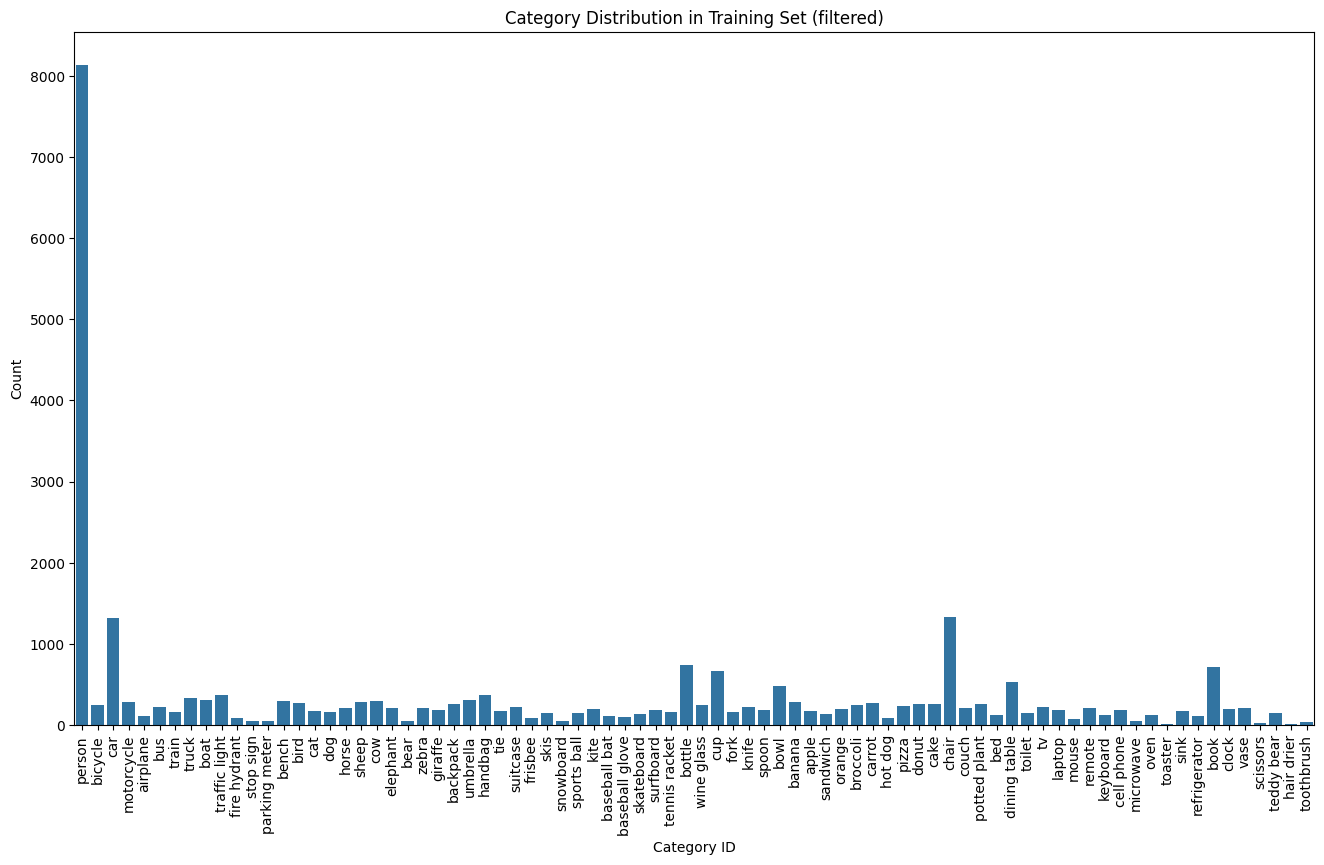

In [22]:
# Convert to DataFrame for easier plotting
df = pd.DataFrame({'category_id': y_train_filtered})
# Count occurrences of each category
category_counts = df['category_id'].value_counts().reset_index()
category_counts.columns = ['category_id', 'count']
# Plot
plt.figure(figsize=(16,9))
sns.barplot(x='category_id', y='count', data=category_counts)
plt.title('Category Distribution in Training Set (filtered)')
plt.xlabel('Category ID')
plt.ylabel('Count')
# set x-ticks to be the category names
category_names = [d['name'] for d in cats]
plt.xticks(range(len(category_names)), category_names)
plt.xticks(rotation=90)
plt.show()

In [23]:
category_counts['count'][0]

np.int64(8135)

In [24]:
# compute the mean and median of number of samples across all classes

category_counts.mean(), category_counts.median()

(category_id     44.9500
 count          335.1375
 dtype: float64,
 category_id     45.0
 count          194.0
 dtype: float64)

Then perform oversampling and undersampling with the transformed tfidf_matrix

Let's test with SMOTE + ENN

https://imbalanced-learn.org/stable/combine.html

https://imbalanced-learn.org/stable/references/generated/imblearn.combine.SMOTEENN.html#imblearn.combine.SMOTEENN

In [25]:
y_train_filtered

array([35,  1,  1, ...,  1,  1,  3])

In [26]:
# first under sampling the "person" class to only 10% of the whole dataset

from imblearn.under_sampling import RandomUnderSampler

random_under_sampler = RandomUnderSampler(sampling_strategy={1: int(category_counts['count'][0] / 6)}, random_state=42)
X_train_res, y_train_res = random_under_sampler.fit_resample(tfidf_matrix, y_train_filtered)

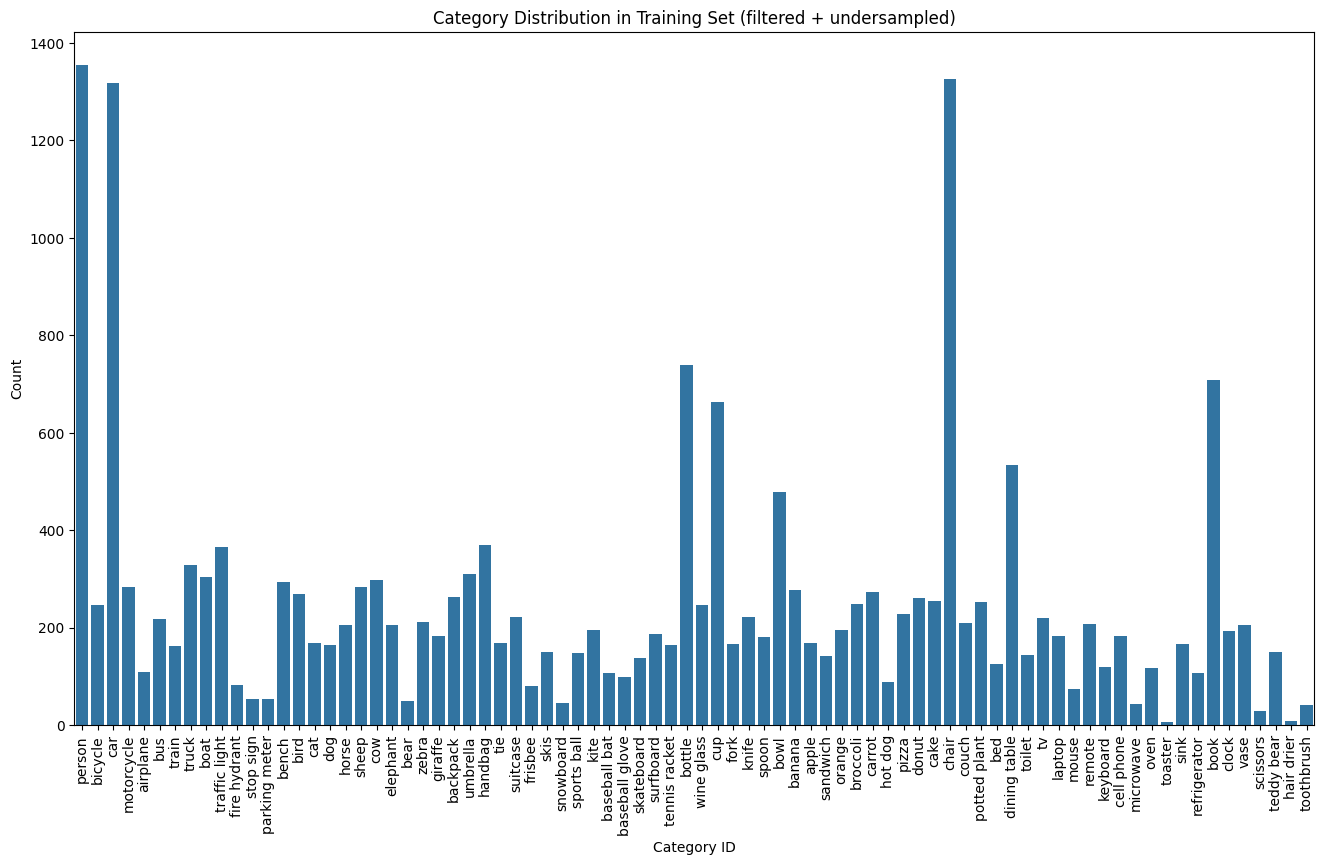

In [27]:
# Convert to DataFrame for easier plotting
df = pd.DataFrame({'category_id': y_train_res})
# Count occurrences of each category
category_counts = df['category_id'].value_counts().reset_index()
category_counts.columns = ['category_id', 'count']
# Plot
plt.figure(figsize=(16,9))
sns.barplot(x='category_id', y='count', data=category_counts)
plt.title('Category Distribution in Training Set (filtered + undersampled)')
plt.xlabel('Category ID')
plt.ylabel('Count')
# set x-ticks to be the category names
category_names = [d['name'] for d in cats]
plt.xticks(range(len(category_names)), category_names)
plt.xticks(rotation=90)
plt.show()

In [28]:
# optional: upsample with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy='not majority', k_neighbors=5, random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train_res, y_train_res)

Then SVM classifier (probably kernel SVM, as suggested by scikit-learn that, it is best to apply a kernel b4 using SGDClassifier)

In [57]:
# SVM, with stochastic gradient descent as optimization

from sklearn.linear_model import SGDClassifier
from sklearn.kernel_approximation import AdditiveChi2Sampler

# add_chi2 = AdditiveChi2Sampler()
svm = SGDClassifier(
    learning_rate='constant', eta0=1e-4, max_iter=1000,
    loss='hinge',
    penalty='l2',
    random_state=42,
    early_stopping=True,
    n_iter_no_change=10,
    validation_fraction=0.1,
    tol=1e-8
)

# X_train_chi2 = add_chi2.fit_transform(X_train_res, y_train_res)
svm.fit(X_train_res, y_train_res)

SGDClassifier(early_stopping=True, eta0=0.0001, learning_rate='constant',
              n_iter_no_change=10, random_state=42, tol=1e-08)

Test against the test set

In [29]:
sift_dataset_testing = create_sift_dataset(X_test, img_ids_w_filename)

Extracting SIFT features (num_proc=2): 100%|██████████| 7357/7357 [00:19<00:00, 372.53 examples/s]


In [34]:
# Apply PCA to the testing dataset

def apply_pca(example, pca):
    """Apply PCA to the example"""

    des = np.array(example['descriptors'])

    # early return if no descriptors
    if des.size == 0:
        example['pca_descriptors'] = np.array([[]], dtype=np.float64)
        return example
    
    if des.ndim == 1:
        example['pca_descriptors'] = pca.transform(des.reshape(1, -1))
    else:
        example['pca_descriptors'] = pca.transform(des)

    return example

sift_dataset_testing = sift_dataset_testing.map(
    apply_pca,
    fn_kwargs={'pca': pca},
    num_proc=1,
    desc="Applying PCA to descriptors"
)

Applying PCA to descriptors: 100%|██████████| 7357/7357 [00:34<00:00, 212.24 examples/s]


In [35]:
# extend the dataset with the cluster id (equivalent to vector quantization)
def assign_cluster_id_inference(example, kmeans):
    """Assign cluster id to each keypoint based on the closest cluster center"""
    # Update the example with the cluster ids

    red_des = np.array(example['pca_descriptors'])

    # early return if no descriptors
    if red_des.size == 0:
        example['cluster_ids'] = np.array([], dtype=np.int32)
        return example

    if red_des.ndim == 1:
        example['cluster_ids'] = kmeans.predict(red_des.reshape(1, -1))
    else:
        example['cluster_ids'] = kmeans.predict(red_des)
    
    return example

sift_dataset_testing = sift_dataset_testing.map(
    assign_cluster_id_inference,
    fn_kwargs={'kmeans': kmeans},
    num_proc=1,
    desc="Assigning cluster ids to keypoints"
)

Assigning cluster ids to keypoints: 100%|██████████| 7357/7357 [00:09<00:00, 747.78 examples/s] 


In [36]:
# Apply the histogram function to the dataset
sift_dataset_testing = sift_dataset_testing.map(
    create_histogram,
    num_proc=1,
    desc="Creating histogram of cluster ids"
)

Creating histogram of cluster ids: 100%|██████████| 7357/7357 [00:26<00:00, 277.26 examples/s]


In [37]:
des_histo_test = np.concatenate(
    [example['histogram'] for example in sift_dataset_testing if len(example['histogram'][0]) > 0],
    axis=0
)

# Convert the list of descriptors to TF-IDF representation
tfidf_matrix_test = tfidf_transformer.transform(des_histo_test)

In [38]:
y_test_filtered = [y_test[i] for i, example in enumerate(sift_dataset_testing) if len(example['histogram'][0]) > 0]
y_test_filtered = np.array(y_test_filtered)

In [39]:
y_test_filtered.shape

(6679,)

In [58]:
# predict

# y_pred = add_chi2.transform(tfidf_matrix_test)
# y_pred = svm.predict(y_pred)

y_pred = svm.predict(tfidf_matrix_test)

Result and evaluation

In [59]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = [d['name'] for d in cats]
print(classification_report(y_test_filtered, y_pred, target_names=target_names, zero_division=0))

                precision    recall  f1-score   support

        person       0.34      0.77      0.47      2034
       bicycle       0.00      0.00      0.00        52
           car       0.08      0.18      0.11       347
    motorcycle       0.00      0.00      0.00        80
      airplane       0.00      0.00      0.00        31
           bus       0.00      0.00      0.00        63
         train       0.00      0.00      0.00        28
         truck       0.00      0.00      0.00        80
          boat       0.00      0.00      0.00        71
 traffic light       0.00      0.00      0.00        94
  fire hydrant       0.00      0.00      0.00        12
     stop sign       0.00      0.00      0.00        13
 parking meter       0.00      0.00      0.00         4
         bench       0.00      0.00      0.00        76
          bird       0.00      0.00      0.00        60
           cat       0.00      0.00      0.00        33
           dog       0.00      0.00      0.00  

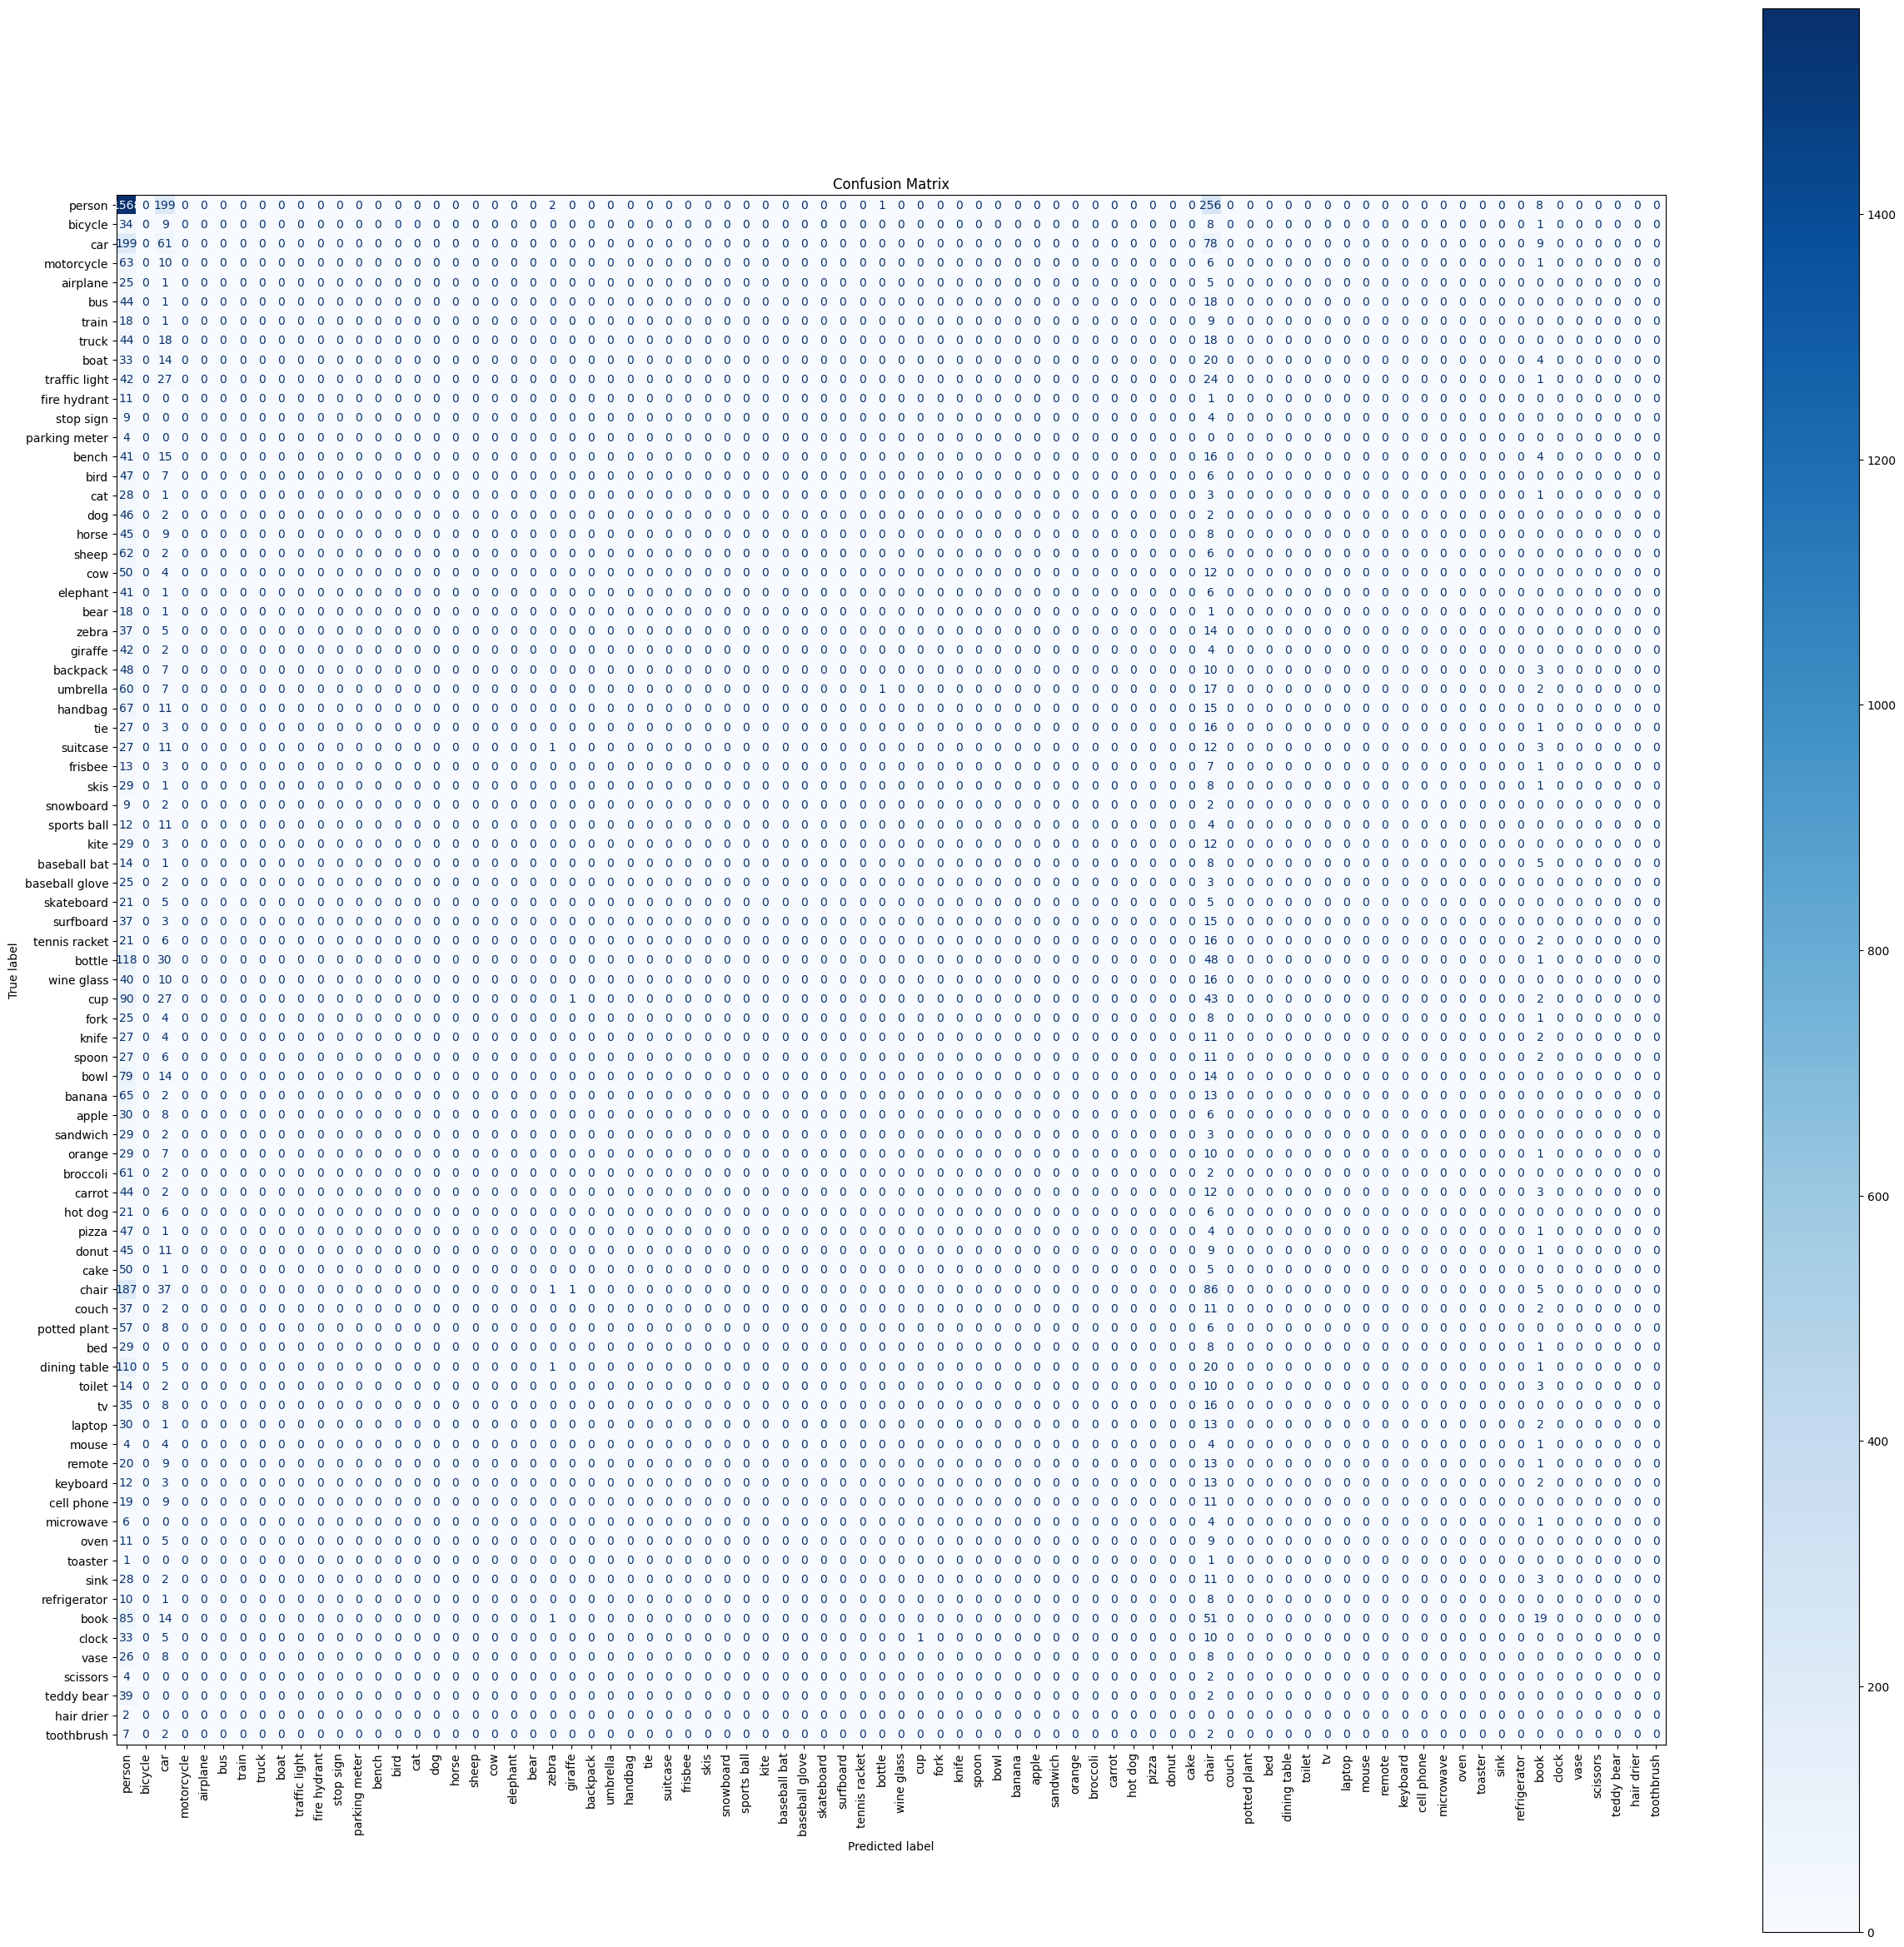

In [60]:
# plot confusion matrix

conf_matirx = confusion_matrix(y_test_filtered, y_pred)

from sklearn.metrics import ConfusionMatrixDisplay
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matirx, display_labels=target_names)

fig, ax = plt.subplots(figsize=(30,30))
ax.set_title('Confusion Matrix')
cm_disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation=90)

In [61]:
# save both classification report and confusion matrix

with open('classification_report.txt', 'w') as f:
    f.write(classification_report(y_test_filtered, y_pred, target_names=target_names, zero_division=0))

fig.savefig('confusion_matrix.png')
plt.close(fig)